In [ ]:
!pip install qiskit

In [ ]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import transpile, schedule as build_schedule
from qiskit.pulse import Schedule, Play, Gaussian, DriveChannel,ShiftPhase, Drag
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import plot_histogram

In [ ]:

IBMQ.save_account('24f1bb2782a6cfdd06501f5146b73ad546e8892fa55e1da503fb632e8400aee65f9bc6ff5f62eca98bb131ea7e71f8420edde7448ecdd1fac11b348161a517ae')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

configrc.store_credentials:WARNING:2020-11-17 07:14:43,775: Credentials already present. Set overwrite=True to overwrite.
/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-11-17 07:14:44,220: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [ ]:
dt = backend_config.dt

print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [ ]:
backend_defaults = backend.defaults()

In [ ]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)


Qubit 0 has an estimated frequency of 4.974447567095812 GHz.


In [ ]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [ ]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play,Drag
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes

drive_sigma_us_base = 0.075
drive_samples_us_base = drive_sigma_us_base*4
drive_amp_base = 0.3
# Drive pulse parameters (us = microseconds)
#drive_sigma_us = 0.035                   # This determines the actual width of the gaussian
#drive_samples_us = drive_sigma_us*4        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length


In [ ]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [ ]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [ ]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [ ]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.8
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [ ]:
test = []
for i in range(20,85,3):
  test.append(i/1000)
samples = []
def baseline_remove(values):
  return np.array(values) - np.mean(values)

In [ ]:
print(test)

[0.02, 0.023, 0.026, 0.029, 0.032, 0.035, 0.038, 0.041, 0.044, 0.047, 0.05, 0.053, 0.056, 0.059, 0.062, 0.065, 0.068, 0.071, 0.074, 0.077, 0.08, 0.083]


In [ ]:
from qiskit import assemble
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [ ]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.


for i in test:
  drive_sigma = get_closest_multiple_of_16(i * us /dt)       # The width of the gaussian in units of dt
  drive_samples = get_closest_multiple_of_16(i * 4 * us /dt)   # The truncating parameter in units of dt
  #drive_amp = drive_amp_base / 1.0 / i
  
  rabi_schedules = []
  for drive_amp in drive_amps:
      rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp,sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
      this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
      this_schedule += Play(rabi_pulse, drive_chan)
      # Reuse the measure instruction from the frequency sweep experiment
      this_schedule += measure << this_schedule.duration
      rabi_schedules.append(this_schedule)
  # Assemble the schedules into a Qobj
  num_shots_per_point = 1024

  rabi_experiment_program = assemble(rabi_schedules,backend=backend,meas_level=1,meas_return='avg',shots=num_shots_per_point,schedule_los=[{drive_chan: backend_defaults.qubit_freq_est[0]}] * num_rabi_points)
  # print(job.job_id())
  job = backend.run(rabi_experiment_program)
  job_monitor(job)
  # center data around 0

  rabi_results = job.result(timeout=120)
  rabi_values = []
  for num_point in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(num_point)[qubit]*scale_factor)
  rabi_values = np.real(baseline_remove(rabi_values))
  fit_params, y_fit = fit_function(drive_amps, rabi_values,lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),[3, 0, 1,0])
  drive_period = fit_params[2] # get period of rabi oscillation
  pi_amp = abs(drive_period / 2)
  print([drive_sigma,drive_samples,pi_amp])
  if(pi_amp <= 1):
    samples.append([drive_sigma,drive_samples,pi_amp])


Job Status: job has successfully run
[96, 368, 0.8803911498821971]
Job Status: job has successfully run
[96, 416, 0.8606382909222071]
Job Status: job has successfully run
[112, 464, 0.8081646743846611]
Job Status: job has successfully run
[128, 528, 0.7568887033449109]
Job Status: job has successfully run
[144, 576, 0.6471987716779701]
Job Status: job has successfully run
[160, 624, 0.5977610131483283]
Job Status: job has successfully run
[176, 688, 0.5546944047931383]
Job Status: job has successfully run
[192, 736, 0.5105679225767973]
Job Status: job has successfully run
[192, 800, 0.4845290084156977]
Job Status: job has successfully run
[208, 848, 0.4414031032533915]
Job Status: job has successfully run
[224, 896, 0.4078682343922708]
Job Status: job has successfully run
[240, 960, 0.38273440403441344]
Job Status: job has successfully run
[256, 1008, 0.3625316551141775]
Job Status: job has successfully run
[272, 1056, 0.34861371438829275]
Job Status: job has successfully run
[272, 112

In [ ]:
print(samples)

[[96, 368, 0.8803911498821971], [96, 416, 0.8606382909222071], [112, 464, 0.8081646743846611], [128, 528, 0.7568887033449109], [144, 576, 0.6471987716779701], [160, 624, 0.5977610131483283], [176, 688, 0.5546944047931383], [192, 736, 0.5105679225767973], [192, 800, 0.4845290084156977], [208, 848, 0.4414031032533915], [224, 896, 0.4078682343922708], [240, 960, 0.38273440403441344], [256, 1008, 0.3625316551141775], [272, 1056, 0.34861371438829275], [272, 1120, 0.33682979033320104], [288, 1168, 0.31914147696862355], [304, 1232, 0.3039575365633026], [320, 1280, 0.2879904952348716], [336, 1328, 0.27753610473460066], [352, 1392, 0.2617470749059488], [368, 1440, 0.2521793696821504], [368, 1488, 0.24731685337884374]]


In [ ]:
import math

In [ ]:
p = 0
l = np.pi
n = "H"
h_result = []
x_result = []
# Ground state
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure
for i in samples:
  #pi_pulse = pulse_lib.gaussian(duration=i[1],amp=i[2],sigma=i[0],name='pi_pulse')
  #Excited state
  exc_schedule = pulse.Schedule(name="excited state")
  exc_schedule += Play(Gaussian(duration=i[1], amp=i[2]+0j, sigma=i[0]), drive_chan)
  exc_schedule += measure << exc_schedule.duration
  #run
  num_shots = 1024
  gnd_exc_program = assemble([gnd_schedule,exc_schedule],backend=backend,meas_level=1,meas_return='single',shots=num_shots)
  job = backend.run(gnd_exc_program)
  job_monitor(job)

  gnd_exc_results = job.result(timeout=120)
  gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
  exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor
  mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
  mean_exc = np.mean(exc_results)

  def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))
  def get_U2_sched(phi,lam,name,dura_i,amp_i,sigma_i):
    sched_circuit = pulse.Schedule(name=name)
    sched_circuit |= ShiftPhase(-lam, drive_chan) 
    sched_circuit |=  Play(Drag(duration=dura_i, amp=amp_i/2, sigma=sigma_i, beta=-3.503413439291586),drive_chan)
    sched_circuit += ShiftPhase(-phi, drive_chan)  
    sched_circuit += measure << sched_circuit.duration
    return sched_circuit
  print(i)
  h_res = []
  x_res = []
  for j in range(0,10):
    # H gate repeat
    sched_circuit = get_U2_sched(p,l,n, i[1],i[2],i[0])
    num_shots = 1024
    h_exc_program = assemble([gnd_schedule,sched_circuit],backend=backend,meas_level=1,meas_return='single',shots=num_shots)
    job = backend.run(h_exc_program)
    job_monitor(job)
    h_exc_results = job.result(timeout=120)
    h_results = h_exc_results.get_memory(1)[:, qubit]*scale_factor
    res = [x for x in [classify(complex(n.real,n.imag)) for n in h_results]]
    h_res.append([res.count(1),res.count(0)])
    #print([res.count(1)])

    # X gate repeat
    sched_circuit = pulse.Schedule(name="X state")
    sched_circuit |=  Play(Gaussian(duration=i[1], amp=i[2], sigma=i[0]),drive_chan)
    sched_circuit += measure << sched_circuit.duration
    num_shots = 1024

    x_exc_program = assemble([gnd_schedule,sched_circuit],backend=backend,meas_level=1,meas_return='single',shots=num_shots)
    job = backend.run(x_exc_program)
    job_monitor(job)
    x_exc_results = job.result(timeout=120)
    x_results = x_exc_results.get_memory(1)[:, qubit]*scale_factor
    res = [x for x in [classify(complex(n.real,n.imag)) for n in x_results]]
    x_res.append([res.count(1),res.count(0)])
    #print([res.count(1)])
  h_result.append(h_res)
  x_result.append(x_res)

Job Status: job has successfully run
[96, 368, 0.8803911498821971]
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[96, 416, 0.8606382909222071]
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job

In [ ]:
h_avg_1 = []
for i in h_result:
  sum = 0
  for v in i:
    sum+=v[0]
  h_avg_1.append(sum/len(i))
print(h_avg_1)

[363.9, 427.9, 452.8, 514.4, 449.3, 431.7, 470.0, 445.3, 466.3, 448.9, 448.5, 441.7, 423.6, 507.0, 458.1, 451.1, 467.6, 528.0, 462.0, 443.5, 457.3, 461.2]


In [ ]:
x_avg_1 = []
for i in x_result:
  sum = 0
  for v in i:
    sum+=v[0]
  x_avg_1.append(sum/len(i))
print(x_avg_1)

[840.2, 911.2, 934.4, 958.2, 934.4, 911.0, 954.9, 946.2, 926.3, 950.6, 946.2, 945.0, 935.2, 949.9, 953.8, 954.1, 960.5, 960.0, 957.7, 946.1, 944.1, 947.5]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

plt.plot(test, h_avg_1)
plt.axhline(512, color='r')

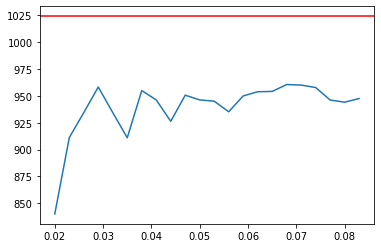

In [ ]:
plt.plot(test, x_avg_1)
plt.axhline(1024, color='r')

In [ ]:
#baseline
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import BasicAer, execute
from qiskit.tools.visualization import plot_histogram


In [ ]:
# Build the phase shift circuit
h_qc = QuantumCircuit(1,1)
h_qc.h(0)
h_qc.measure(0,0)
h_qc.draw()

┌───┐┌─┐
q_0: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

In [ ]:

# Build the phase shift circuit
h_qc = QuantumCircuit(1,1)
h_qc.h(0)
h_qc.measure(0,0)
hsum = 0
for i in range(0,10):
  job = execute(h_qc, backend, shots=1024)  # shots default = 1024
  hresult = job.result()
  hsum += hresult.get_counts().get('1')

print(sum/10)

In [ ]:
# Build the phase shift circuit
x_qc = QuantumCircuit(1,1)
x_qc.x(0)
x_qc.measure(0,0)
x_qc.draw()

┌───┐┌─┐
q_0: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

In [ ]:
xsum = 0
for i in range(0,10):
  job = execute(x_qc, backend, shots=1024)  # shots default = 1024
  xresult = job.result()
  xsum += xresult.get_counts().get('1')


In [ ]:
amps = []
for i in samples:
  amps.append(i[2])

In [ ]:
print(amps)

[0.8803911498821971, 0.8606382909222071, 0.8081646743846611, 0.7568887033449109, 0.6471987716779701, 0.5977610131483283, 0.5546944047931383, 0.5105679225767973, 0.4845290084156977, 0.4414031032533915, 0.4078682343922708, 0.38273440403441344, 0.3625316551141775, 0.34861371438829275, 0.33682979033320104, 0.31914147696862355, 0.3039575365633026, 0.2879904952348716, 0.27753610473460066, 0.2617470749059488, 0.2521793696821504, 0.24731685337884374]


In [ ]:
plt.plot(amps, h_avg_1)
plt.axhline(512, color='r')

NameError: ignored

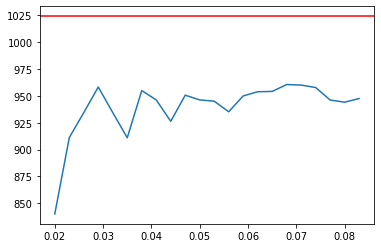

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
amps = [0.8803911498821971, 0.8606382909222071, 0.8081646743846611, 0.7568887033449109, 0.6471987716779701, 0.5977610131483283, 0.5546944047931383, 0.5105679225767973, 0.4845290084156977, 0.4414031032533915, 0.4078682343922708, 0.38273440403441344, 0.3625316551141775, 0.34861371438829275, 0.33682979033320104, 0.31914147696862355, 0.3039575365633026, 0.2879904952348716, 0.27753610473460066, 0.2617470749059488, 0.2521793696821504, 0.24731685337884374]

In [ ]:
h_avg = [363.9, 427.9, 452.8, 514.4, 449.3, 431.7, 470.0, 445.3, 466.3, 448.9, 448.5, 441.7, 423.6, 507.0, 458.1, 451.1, 467.6, 528.0, 462.0, 443.5, 457.3, 461.2]

In [ ]:
x_avg = [840.2, 911.2, 934.4, 958.2, 934.4, 911.0, 954.9, 946.2, 926.3, 950.6, 946.2, 945.0, 935.2, 949.9, 953.8, 954.1, 960.5, 960.0, 957.7, 946.1, 944.1, 947.5]

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import BasicAer, execute
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import transpile, schedule as build_schedule
from qiskit.pulse import Schedule, Play, Gaussian, DriveChannel,ShiftPhase, Drag
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import plot_histogram

In [ ]:
IBMQ.save_account('24f1bb2782a6cfdd06501f5146b73ad546e8892fa55e1da503fb632e8400aee65f9bc6ff5f62eca98bb131ea7e71f8420edde7448ecdd1fac11b348161a517ae')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

configrc.store_credentials:WARNING:2020-11-17 12:07:07,448: Credentials already present. Set overwrite=True to overwrite.
/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-11-17 12:07:08,015: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# Build the phase shift circuit
h_qc = QuantumCircuit(1,1)
h_qc.h(0)
h_qc.measure(0,0)
h_qc.draw()

┌───┐┌─┐
q_0: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

In [ ]:
hsum = 0
for i in range(0,10):
  job = execute(h_qc, backend, shots=1024)  # shots default = 1024
  hresult = job.result()
  hsum += hresult.get_counts().get('1')

base_h = hsum/10
print(base_h)

In [ ]:
# Build the phase shift circuit
x_qc = QuantumCircuit(1,1)
x_qc.x(0)
x_qc.measure(0,0)
x_qc.draw()

┌───┐┌─┐
q_0: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

In [ ]:
xsum = 0
for i in range(0,10):
  job = execute(x_qc, backend, shots=1024)  # shots default = 1024
  xresult = job.result()
  xsum += xresult.get_counts().get('1')
base_x = xsum/10
print(base_x)

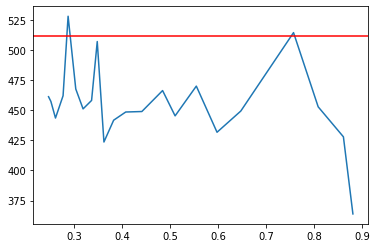

In [ ]:
plt.plot(amps, h_avg)
plt.axhline(512, color='r')

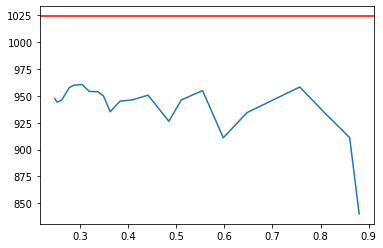

In [ ]:
plt.plot(amps, x_avg)
plt.axhline(1024, color='r')